In [29]:
from osgeo import gdal,osr,ogr
import numpy as np
import os
import sys
import glob
from datetime import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import xarray as xr
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians, atan
import matplotlib.dates as mdates

In [30]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def calc_distance(lon1,lat1,lon2,lat2):
    R = 6373.0
    lon1=np.array([radians(lon) for lon in lon1])
    lat1=np.array([radians(lat) for lat in lat1])
    lon2=np.array([radians(lon) for lon in lon2])
    lat2=np.array([radians(lat) for lat in lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
#    print(dlon,dlat)
    a = np.array([sin(dlat[i] / 2)**2 + cos(lat1[i]) * cos(lat2[i]) * sin(dlon[i] / 2)**2 for i in range(lon1.shape[0])])
#    print(a)
    c = np.array([2 * atan2(sqrt(a[i]), sqrt(1 - a[i])) for i in range(lon1.shape[0])])
    distance = R * c
#    print(a.shape)
    return distance



linear_interpolation=lambda v1,v2,v3,v4,dx,dy:(1.-dx)*(1.-dy)*v1 + dx*(1.-dy)*v2 + dx*dy*v3 + (1.-dx)*dy*v4
vector_transformation=lambda u,v,dx,dy: v*cos(atan2(dx,dy))-u*sin(atan2(dx,dy))
#print(vector_transformation(1,1,1,0))

In [31]:
era5_dir=r'../ERA5'
points=r'../polynya_definition/atmosphere_point.shp'
shp = ogr.Open(points, 0)
shp_lyr = shp.GetLayer(0)
featureCount = shp_lyr.GetFeatureCount()
print(featureCount)
#shp_lyr.SetAttributeFilter("id =" +str(pid))

pname_list=[]
pid_list=[]
rx_list=[]
ry_list=[]
lon_list=[]
lat_list=[]
for i,feature in enumerate(shp_lyr):
    [(lon,lat)] = feature.GetGeometryRef().GetPoints()
#    print(lon,lat)
    lon = round(lon*4)/4
    if lon<0:
        lon=lon+360
    lat = round(lat*4)/4
    
    #test
#     lon=130
#     lat=-65
    
    rx = int(lon * 4)
    ry = int((-lat-50) * 4) 
    rx_list.append(rx)
    ry_list.append(ry)
    lon_list.append(lon)
    lat_list.append(lat)
    pid_list.append(feature.GetField("id"))
    pname_list.append(feature.GetField("pol_name"))
    
    print(pid_list[i],pname_list[i],lon,lat,rx,ry)

17
1 CDP 69.5 -67.5 278 70
2 MBP 71.0 -68.5 284 74
3 BaP 81.0 -67.5 324 70
4 SP 95.25 -66.0 381 64
5 VBP 109.25 -66.5 437 66
7 DaP 120.75 -66.25 483 65
8 DiP 134.0 -65.5 536 62
9 MP 145.0 -67.0 580 68
10 TNBP 164.0 -75.25 656 101
11 RISP 173.25 -77.25 693 109
12 AP 248.5 -74.0 994 96
13 BeP 279.0 -73.0 1116 92
14 RONP 300.25 -75.0 1201 100
6 PP 113.5 -65.5 454 62
15 ELISP 13.5 -69.5 54 78
16 BISP 19.25 -69.75 77 79
17 BBP 24.5 -70.25 98 81


In [32]:
dlon=np.zeros(25)
dlat=np.zeros(25)
inum=0
imax=5
jmax=5
for j in range(jmax):
    for i in range(imax):
        dlon[inum]=imax-float(i)-(imax+1)/2
        dlat[inum]=(jmax-float(j)-(jmax+1)/2)*0.25 
        inum=inum+1
        
print(dlon)
print(dlat)

[ 2.  1.  0. -1. -2.  2.  1.  0. -1. -2.  2.  1.  0. -1. -2.  2.  1.  0.
 -1. -2.  2.  1.  0. -1. -2.]
[ 0.5   0.5   0.5   0.5   0.5   0.25  0.25  0.25  0.25  0.25  0.    0.
  0.    0.    0.   -0.25 -0.25 -0.25 -0.25 -0.25 -0.5  -0.5  -0.5  -0.5
 -0.5 ]


In [33]:



u10_list=[]
v10_list=[]
t2m_list=[]
date_list=[]
for year in range(2003, 2011):
    for month in range(4,11):
        day='01'
        strdt = dt.strptime(str(year) + str(month) + day, '%Y%m%d')
        enddt = strdt + relativedelta(months=1)-timedelta(days=1)

        days_num = (enddt - strdt).days + 1
        datelist = [strdt + timedelta(days=x) for x in range(days_num)]

        era5Data = os.path.join(era5_dir,'era5_' + enddt.strftime("%Y%m") + '.nc')
        ds = xr.open_dataset(era5Data)

        for d in datelist:
            date=d.strftime("%Y%m%d")
            
            u10_list02=[]
            v10_list02=[]
            t2m_list02=[]
            
            for j in range(25):
                
                u10_list0=[]
                v10_list0=[]
                t2m_list0=[]
                
                for i in range(17):

                    lon=lon_list[i]+dlon[j]
                    lat=lat_list[i]+dlat[j]
                    rx=rx_list[i]
                    ry=ry_list[i]
                    date2=date+timedelta(days=1)
                    u10=np.mean(ds.u10.sel(longitude=lon, latitude=lat,time=slice(date,date)),axis=0)
                    v10=np.mean(ds.v10.sel(longitude=lon, latitude=lat,time=slice(date,date)),axis=0)
                    t2m=np.mean(ds.t2m.sel(longitude=lon, latitude=lat,time=slice(date,date)),axis=0)
                    u10_list0.append(u10.values)
                    v10_list0.append(v10.values)
                    t2m_list0.append(t2m.values)

   
                u10_list02.extend(u10_list0)
                v10_list02.extend(v10_list0)
                t2m_list02.extend(t2m_list0)
            
            u10_list.append(u10_list02)
            v10_list.append(v10_list02)
            t2m_list.append(t2m_list02)
            date_list.append(d)
            print(d)             
print("finish")



2003-04-01 00:00:00
2003-04-02 00:00:00
2003-04-03 00:00:00
2003-04-04 00:00:00
2003-04-05 00:00:00
2003-04-06 00:00:00
2003-04-07 00:00:00
2003-04-08 00:00:00
2003-04-09 00:00:00
2003-04-10 00:00:00
2003-04-11 00:00:00
2003-04-12 00:00:00
2003-04-13 00:00:00
2003-04-14 00:00:00
2003-04-15 00:00:00
2003-04-16 00:00:00
2003-04-17 00:00:00
2003-04-18 00:00:00
2003-04-19 00:00:00
2003-04-20 00:00:00
2003-04-21 00:00:00
2003-04-22 00:00:00
2003-04-23 00:00:00
2003-04-24 00:00:00
2003-04-25 00:00:00
2003-04-26 00:00:00
2003-04-27 00:00:00
2003-04-28 00:00:00
2003-04-29 00:00:00
2003-04-30 00:00:00
2003-05-01 00:00:00
2003-05-02 00:00:00
2003-05-03 00:00:00
2003-05-04 00:00:00
2003-05-05 00:00:00
2003-05-06 00:00:00
2003-05-07 00:00:00
2003-05-08 00:00:00
2003-05-09 00:00:00
2003-05-10 00:00:00
2003-05-11 00:00:00
2003-05-12 00:00:00
2003-05-13 00:00:00
2003-05-14 00:00:00
2003-05-15 00:00:00
2003-05-16 00:00:00
2003-05-17 00:00:00
2003-05-18 00:00:00
2003-05-19 00:00:00
2003-05-20 00:00:00


2004-10-14 00:00:00
2004-10-15 00:00:00
2004-10-16 00:00:00
2004-10-17 00:00:00
2004-10-18 00:00:00
2004-10-19 00:00:00
2004-10-20 00:00:00
2004-10-21 00:00:00
2004-10-22 00:00:00
2004-10-23 00:00:00
2004-10-24 00:00:00
2004-10-25 00:00:00
2004-10-26 00:00:00
2004-10-27 00:00:00
2004-10-28 00:00:00
2004-10-29 00:00:00
2004-10-30 00:00:00
2004-10-31 00:00:00
2005-04-01 00:00:00
2005-04-02 00:00:00
2005-04-03 00:00:00
2005-04-04 00:00:00
2005-04-05 00:00:00
2005-04-06 00:00:00
2005-04-07 00:00:00
2005-04-08 00:00:00
2005-04-09 00:00:00
2005-04-10 00:00:00
2005-04-11 00:00:00
2005-04-12 00:00:00
2005-04-13 00:00:00
2005-04-14 00:00:00
2005-04-15 00:00:00
2005-04-16 00:00:00
2005-04-17 00:00:00
2005-04-18 00:00:00
2005-04-19 00:00:00
2005-04-20 00:00:00
2005-04-21 00:00:00
2005-04-22 00:00:00
2005-04-23 00:00:00
2005-04-24 00:00:00
2005-04-25 00:00:00
2005-04-26 00:00:00
2005-04-27 00:00:00
2005-04-28 00:00:00
2005-04-29 00:00:00
2005-04-30 00:00:00
2005-05-01 00:00:00
2005-05-02 00:00:00


2006-09-26 00:00:00
2006-09-27 00:00:00
2006-09-28 00:00:00
2006-09-29 00:00:00
2006-09-30 00:00:00
2006-10-01 00:00:00
2006-10-02 00:00:00
2006-10-03 00:00:00
2006-10-04 00:00:00
2006-10-05 00:00:00
2006-10-06 00:00:00
2006-10-07 00:00:00
2006-10-08 00:00:00
2006-10-09 00:00:00
2006-10-10 00:00:00
2006-10-11 00:00:00
2006-10-12 00:00:00
2006-10-13 00:00:00
2006-10-14 00:00:00
2006-10-15 00:00:00
2006-10-16 00:00:00
2006-10-17 00:00:00
2006-10-18 00:00:00
2006-10-19 00:00:00
2006-10-20 00:00:00
2006-10-21 00:00:00
2006-10-22 00:00:00
2006-10-23 00:00:00
2006-10-24 00:00:00
2006-10-25 00:00:00
2006-10-26 00:00:00
2006-10-27 00:00:00
2006-10-28 00:00:00
2006-10-29 00:00:00
2006-10-30 00:00:00
2006-10-31 00:00:00
2007-04-01 00:00:00
2007-04-02 00:00:00
2007-04-03 00:00:00
2007-04-04 00:00:00
2007-04-05 00:00:00
2007-04-06 00:00:00
2007-04-07 00:00:00
2007-04-08 00:00:00
2007-04-09 00:00:00
2007-04-10 00:00:00
2007-04-11 00:00:00
2007-04-12 00:00:00
2007-04-13 00:00:00
2007-04-14 00:00:00


2008-09-08 00:00:00
2008-09-09 00:00:00
2008-09-10 00:00:00
2008-09-11 00:00:00
2008-09-12 00:00:00
2008-09-13 00:00:00
2008-09-14 00:00:00
2008-09-15 00:00:00
2008-09-16 00:00:00
2008-09-17 00:00:00
2008-09-18 00:00:00
2008-09-19 00:00:00
2008-09-20 00:00:00
2008-09-21 00:00:00
2008-09-22 00:00:00
2008-09-23 00:00:00
2008-09-24 00:00:00
2008-09-25 00:00:00
2008-09-26 00:00:00
2008-09-27 00:00:00
2008-09-28 00:00:00
2008-09-29 00:00:00
2008-09-30 00:00:00
2008-10-01 00:00:00
2008-10-02 00:00:00
2008-10-03 00:00:00
2008-10-04 00:00:00
2008-10-05 00:00:00
2008-10-06 00:00:00
2008-10-07 00:00:00
2008-10-08 00:00:00
2008-10-09 00:00:00
2008-10-10 00:00:00
2008-10-11 00:00:00
2008-10-12 00:00:00
2008-10-13 00:00:00
2008-10-14 00:00:00
2008-10-15 00:00:00
2008-10-16 00:00:00
2008-10-17 00:00:00
2008-10-18 00:00:00
2008-10-19 00:00:00
2008-10-20 00:00:00
2008-10-21 00:00:00
2008-10-22 00:00:00
2008-10-23 00:00:00
2008-10-24 00:00:00
2008-10-25 00:00:00
2008-10-26 00:00:00
2008-10-27 00:00:00


2010-08-21 00:00:00
2010-08-22 00:00:00
2010-08-23 00:00:00
2010-08-24 00:00:00
2010-08-25 00:00:00
2010-08-26 00:00:00
2010-08-27 00:00:00
2010-08-28 00:00:00
2010-08-29 00:00:00
2010-08-30 00:00:00
2010-08-31 00:00:00
2010-09-01 00:00:00
2010-09-02 00:00:00
2010-09-03 00:00:00
2010-09-04 00:00:00
2010-09-05 00:00:00
2010-09-06 00:00:00
2010-09-07 00:00:00
2010-09-08 00:00:00
2010-09-09 00:00:00
2010-09-10 00:00:00
2010-09-11 00:00:00
2010-09-12 00:00:00
2010-09-13 00:00:00
2010-09-14 00:00:00
2010-09-15 00:00:00
2010-09-16 00:00:00
2010-09-17 00:00:00
2010-09-18 00:00:00
2010-09-19 00:00:00
2010-09-20 00:00:00
2010-09-21 00:00:00
2010-09-22 00:00:00
2010-09-23 00:00:00
2010-09-24 00:00:00
2010-09-25 00:00:00
2010-09-26 00:00:00
2010-09-27 00:00:00
2010-09-28 00:00:00
2010-09-29 00:00:00
2010-09-30 00:00:00
2010-10-01 00:00:00
2010-10-02 00:00:00
2010-10-03 00:00:00
2010-10-04 00:00:00
2010-10-05 00:00:00
2010-10-06 00:00:00
2010-10-07 00:00:00
2010-10-08 00:00:00
2010-10-09 00:00:00


(213, 1)
1 CDP
2 MBP
3 BaP
4 SP
5 VBP
7 DaP
8 DiP
9 MP
10 TNBP
11 RISP
12 AP
13 BeP
14 RONP
6 PP
15 ELISP
16 BISP
17 BBP


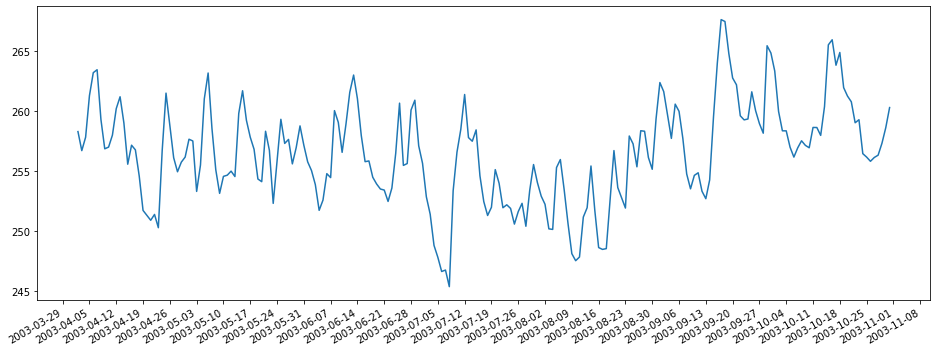

In [37]:
data_array=np.array(t2m_list)[1498:1711,0:1]
print(data_array.shape)
#wind_score_array=np.array(wind_score_list)
#print(data_array)
for i in range(17):
    print(pid_list[i],pname_list[i])

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(date_list[1:214], data_array)

##以下をカスタマイズする
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
daysFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(daysFmt)
fig.autofmt_xdate()

plt.show()

In [34]:
u10_array = np.array(u10_list)
v10_array = np.array(v10_list)
t2m_array = np.array(t2m_list)
print(u10_array.shape)
np.save('u10.npy', u10_array)
np.save('v10.npy', v10_array)
np.save('t2m.npy', t2m_array)

(1712, 425)


In [35]:
test=np.load('t2m.npy')
print(test.shape)
print(test)

(1712, 425)
[[258.98746 257.2406  266.49753 ... 264.42807 262.49246 259.63486]
 [259.86264 258.01273 269.84677 ... 262.8306  260.9291  258.538  ]
 [262.30182 263.135   265.22086 ... 263.5177  261.801   259.36917]
 ...
 [257.0331  254.99611 257.44754 ... 261.4622  261.6693  261.94345]
 [259.99393 257.4609  258.85614 ... 261.4923  264.1321  262.97488]
 [264.5419  264.04965 263.35373 ... 263.32727 262.48056 260.81415]]
